In [1]:
import numpy as np
import pandas as pd

import phik
import math

import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [4]:
test = pd.read_csv('../data/test.csv')
test.shape

(565892, 55)

In [3]:
train = pd.read_csv('../data/train.csv')
train.shape

(15120, 56)

## Conclusions from the EDA:

- there's two types of quantitative/numerical data: continuous and discrete (binary)
- the dataset is free of nulls and duplicates
- the features 'Elevation', 'Horizontal Distance To Fire Points' and 'Horizontal Distance To Roadways' present high cardinality, but not enough to be removed
- only 'Vertical Distance To Hydrology' has negative values
- there's two colums ('Soil Type15' and 'Soil Type7') only with 0s, and many others with few 1s
- few features have correlation with the target
- hte target is perfectly balanced

 - the target is balanced:

In [5]:
train['Cover_Type'].value_counts()

5    2160
2    2160
1    2160
7    2160
3    2160
6    2160
4    2160
Name: Cover_Type, dtype: int64

 - outliers:

In [7]:
def number_of_outliers(df):
    
    df = df.select_dtypes(exclude = 'object')
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    return ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

In [8]:
number_of_outliers(train).sort_values().tail(10)

Soil_Type32                         690
Soil_Type30                         725
Soil_Type38                         728
Soil_Type23                         757
Horizontal_Distance_To_Roadways     830
Soil_Type4                          843
Soil_Type3                          962
Soil_Type29                        1291
Soil_Type10                        2142
Wilderness_Area1                   3597
dtype: int64

In [13]:
print('outliers in Wilderness Area 1: ' + str(3597/len(train)) + ' %')

outliers in Wilderness_Area1: 0.23789682539682538 %


 - As the outliers reflect the amplitude of the forest, we decide to keep them, and to choose robust algorithms based in decision trees. 

## 1. Drop features with constant (or almost constant) values and id

In [20]:
train.shape

(15120, 56)

In [26]:
train.sum().sort_values().head(10)

Soil_Type7      0
Soil_Type15     0
Soil_Type25     1
Soil_Type8      1
Soil_Type28     9
Soil_Type36    10
Soil_Type9     10
Soil_Type27    15
Soil_Type21    16
Soil_Type34    22
dtype: int64

In [24]:
df = train.drop(columns= ['Soil_Type7', 'Soil_Type15', 'Soil_Type25', 'Soil_Type8', 'Id'])
df.shape

## 2. Correlations:

In [28]:
train = df

 - Pearson correlation:

In [31]:
train.corrwith(train['Cover_Type']).sort_values().head(10)

Wilderness_Area1                     -0.230117
Soil_Type29                          -0.218564
Soil_Type22                          -0.195993
Soil_Type23                          -0.158762
Soil_Type32                          -0.132312
Soil_Type12                          -0.129985
Horizontal_Distance_To_Roadways      -0.105662
Soil_Type24                          -0.100797
Hillshade_Noon                       -0.098905
Horizontal_Distance_To_Fire_Points   -0.089389
dtype: float64

In [32]:
train.corrwith(train['Cover_Type']).sort_values().tail(10)

Vertical_Distance_To_Hydrology    0.075647
Wilderness_Area4                  0.075774
Slope                             0.087722
Soil_Type35                       0.114327
Wilderness_Area3                  0.122146
Soil_Type10                       0.128972
Soil_Type40                       0.205851
Soil_Type39                       0.240384
Soil_Type38                       0.257810
Cover_Type                        1.000000
dtype: float64

- Phik correlation:

In [42]:
train.phik_matrix()['Cover_Type'].sort_values(ascending = False).head(25)

interval columns not set, guessing: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']


Cover_Type                            1.000000
Elevation                             0.801070
Wilderness_Area4                      0.754222
Horizontal_Distance_To_Roadways       0.494676
Soil_Type10                           0.492620
Soil_Type3                            0.483691
Wilderness_Area1                      0.483618
Soil_Type38                           0.445401
Horizontal_Distance_To_Fire_Points    0.440710
Soil_Type39                           0.419907
Wilderness_Area3                      0.361451
Soil_Type40                           0.353390
Soil_Type30                           0.326813
Soil_Type29                           0.322441
Horizontal_Distance_To_Hydrology      0.311203
Hillshade_9am                         0.303495
Hillshade_3pm                         0.292085
Aspect                                0.291317
Slope                                 0.281308
Soil_Type4                            0.279328
Soil_Type22                           0.271595
Soil_Type17  

 - Thanks to the Phik correlation, we see that there are high correlations with the target, which helps us for the creation of new features.

## 3. Create new features:

In [45]:
train['eDist_to_Hydrology'] = (train['Horizontal_Distance_To_Hydrology']**2 + train['Vertical_Distance_To_Hydrology']**2)**0.5 
train['human_presence'] = train['Horizontal_Distance_To_Roadways'] + train['Horizontal_Distance_To_Fire_Points']
train['Total_Hillshade_mean'] = (train['Hillshade_9am'] + train['Hillshade_3pm'] + train['Hillshade_Noon']) / 3
train['Elevation_Aspect_ratio'] = train['Elevation']/(train['Aspect']+1)
train['Horizontal_Distance_To_Roadways_Log'] = [math.log(v+1) for v in train['Horizontal_Distance_To_Roadways']]
train['Hillshade_Noon_Aspect_ratio'] = train['Hillshade_Noon']/(train['Aspect']+1)
train['Hillshade_Noon_Elevation_ratio'] = train['Hillshade_Noon']/(train['Elevation']+1)
train['Hillshade_9am_Elevation_ratio'] = train['Hillshade_9am']/(train['Elevation']+1)


In [46]:
train.phik_matrix()['Cover_Type'].sort_values(ascending = False).head(25)

interval columns not set, guessing: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type', 'eDist_to_Hydrology', 'human_presence', 'Total_Hillshade_mean', 'Elevation_Aspect_ratio', 'Horizontal_Distanc

Cover_Type                             1.000000
Elevation                              0.801070
Wilderness_Area4                       0.754222
Hillshade_Noon_Elevation_ratio         0.617592
Hillshade_9am_Elevation_ratio          0.616461
human_presence                         0.527059
Horizontal_Distance_To_Roadways        0.494676
Soil_Type10                            0.492620
Soil_Type3                             0.483691
Wilderness_Area1                       0.483618
Soil_Type38                            0.445401
Horizontal_Distance_To_Fire_Points     0.440710
Horizontal_Distance_To_Roadways_Log    0.434802
Soil_Type39                            0.419907
Wilderness_Area3                       0.361451
Soil_Type40                            0.353390
Soil_Type30                            0.326813
Soil_Type29                            0.322441
Horizontal_Distance_To_Hydrology       0.311203
eDist_to_Hydrology                     0.308649
Hillshade_9am                          0

In [47]:
# train.to_csv('../data/train_newfeats.csv', index = False)

In [22]:
train = pd.read_csv('../data/train_newfeats.csv')

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import lightgbm as lgb
import xgboost


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.feature_selection import SelectKBest

from sklearn.pipeline import Pipeline

In [24]:

X= train.drop(['Cover_Type'], axis=1) 
y= train['Cover_Type']
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2)

In [25]:
# initialize the classificators
rfc= RandomForestClassifier(random_state=77)
gbc= GradientBoostingClassifier(random_state=77)
ada = AdaBoostClassifier(random_state=77)
etc = ExtraTreesClassifier(random_state=77)
lgbm = lgb.LGBMClassifier(random_state=77)

# now, create a list with the objects 
models= [rfc, gbc, ada, etc, lgbm]

In [27]:
for model in models:
    model.fit(X_train, y_train) 
    train_score= model.score(X_train, y_train) 
    test_score= model.score(X_test, y_test)
    #clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
    print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
    #print(clf_report)
    print("\n")

The score in train of model RandomForestClassifier is 1.00
The score in test of model RandomForestClassifier is 0.86


The score in train of model GradientBoostingClassifier is 0.86
The score in test of model GradientBoostingClassifier is 0.80


The score in train of model AdaBoostClassifier is 0.35
The score in test of model AdaBoostClassifier is 0.35


The score in train of model ExtraTreesClassifier is 1.00
The score in test of model ExtraTreesClassifier is 0.87


The score in train of model LGBMClassifier is 0.99
The score in test of model LGBMClassifier is 0.86




In [28]:
from sklearn.feature_selection import SelectKBest

print(X.shape)
sel = SelectKBest(k=5)
X_new = sel.fit_transform(X, y)
names = X.columns

print(X_new.shape)

best_feats = pd.DataFrame({'column': names, 'score': sel.scores_}).sort_values('score', ascending=False)
best_feats.head(10)

(15120, 58)
(15120, 5)


,column,score
0,Elevation,16241.233317
13,Wilderness_Area4,5072.497908
56,Hillshade_Noon_Elevation_ratio,3253.727103
57,Hillshade_9am_Elevation_ratio,2644.415899
51,human_presence,1469.962628
5,Horizontal_Distance_To_Roadways,1223.070458
21,Soil_Type10,977.737621
54,Horizontal_Distance_To_Roadways_Log,972.271891
16,Soil_Type3,929.217593
10,Wilderness_Area1,928.831132


In [18]:
X= train[['Elevation', 'Hillshade_Noon_Elevation_ratio', 'Hillshade_9am_Elevation_ratio', 'human_presence', 'Horizontal_Distance_To_Roadways', 
 'Horizontal_Distance_To_Roadways_Log']]
y= train['Cover_Type']
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2)

In [19]:
for model in models:
    model.fit(X_train, y_train) 
    train_score= model.score(X_train, y_train) 
    test_score= model.score(X_test, y_test)
    #clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
    print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
    #print(clf_report)
    print("\n")

The score in train of model RandomForestClassifier is 1.00
The score in test of model RandomForestClassifier is 0.81


The score in train of model GradientBoostingClassifier is 0.79
The score in test of model GradientBoostingClassifier is 0.74


The score in train of model AdaBoostClassifier is 0.43
The score in test of model AdaBoostClassifier is 0.43


The score in train of model ExtraTreesClassifier is 1.00
The score in test of model ExtraTreesClassifier is 0.82


The score in train of model LGBMClassifier is 0.95
The score in test of model LGBMClassifier is 0.80





- non-gaussian dist (apply MinMaxScaling)
- gaussian dist (apply StandardScaler) : Slope and Hillshade_3pm

In [ ]:
# 'Elevation', 'Aspect', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points'

In [117]:
from sklearn.preprocessing import MinMaxScaler

scaler_mms = MinMaxScaler()

test[['Elevation', 'Aspect', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points']] = scaler_mms.fit_transform(test[['Elevation', 'Aspect', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points']])
train[['Elevation', 'Aspect', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points']] = scaler_mms.fit_transform(train[['Elevation', 'Aspect', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points']])

In [118]:
from sklearn.preprocessing import StandardScaler
scaler_ss = MinMaxScaler()

test[['Slope', 'Hillshade_3pm']] = scaler_ss.fit_transform(test[['Slope', 'Hillshade_3pm']])
train[['Slope', 'Hillshade_3pm']] = scaler_ss.fit_transform(train[['Slope', 'Hillshade_3pm']])

In [138]:
train.shape

(15120, 56)

In [139]:
test.shape

(565892, 55)

In [141]:
train.to_csv('train_scaled.csv', index=False)

In [142]:
test.to_csv('test_scaled.csv', index=False)

In [119]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,0.369084,0.141667,0.057692,0.192107,0.208571,0.074020,0.870079,0.858065,0.596774,...,0,0,0,0,0,0,0,0,0,5
1,2,0.366062,0.155556,0.038462,0.157856,0.200000,0.056604,0.866142,0.877419,0.608871,...,0,0,0,0,0,0,0,0,0,5
2,3,0.473817,0.386111,0.173077,0.199553,0.301429,0.461538,0.921260,0.896774,0.544355,...,0,0,0,0,0,0,0,0,0,2
3,4,0.464250,0.430556,0.346154,0.180194,0.377143,0.448476,0.937008,0.896774,0.491935,...,0,0,0,0,0,0,0,0,0,2
4,5,0.368580,0.125000,0.038462,0.113924,0.207143,0.056749,0.866142,0.870968,0.604839,...,0,0,0,0,0,0,0,0,0,5


In [120]:
train.iloc[:, :20].describe().round(2)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5
count,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00
mean,7560.50,0.45,0.44,0.32,0.17,0.28,0.25,0.84,0.77,0.54,0.22,0.24,0.03,0.42,0.31,0.02,0.04,0.06,0.06,0.01
std,4364.91,0.21,0.31,0.16,0.16,0.09,0.19,0.12,0.15,0.19,0.16,0.43,0.18,0.49,0.46,0.15,0.20,0.24,0.23,0.10
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3780.75,0.26,0.18,0.19,0.05,0.22,0.11,0.77,0.70,0.43,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,7560.50,0.45,0.35,0.29,0.13,0.25,0.19,0.87,0.80,0.56,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,11340.25,0.62,0.72,0.42,0.25,0.32,0.33,0.93,0.88,0.67,0.28,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
max,15120.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [126]:
abs(train.corrwith(train['Cover_Type'])).sort_values(ascending=False).head(7)

Cover_Type          1.000000
Soil_Type38         0.257810
Soil_Type39         0.240384
Wilderness_Area1    0.230117
Soil_Type29         0.218564
Soil_Type40         0.205851
Soil_Type22         0.195993
dtype: float64

In [136]:
correlatio = train[['Cover_Type','Soil_Type38', 'Soil_Type39', 'Wilderness_Area1', 'Soil_Type29', 'Soil_Type40', 'Soil_Type22']]

<AxesSubplot:>

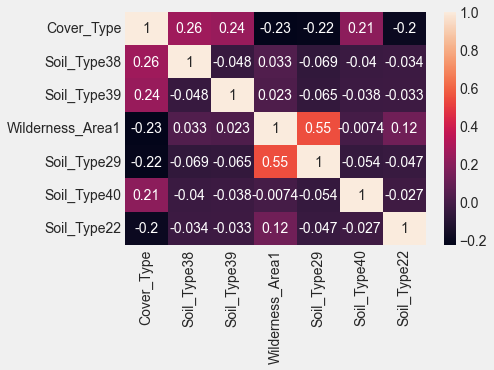

In [137]:
sns.heatmap(correlatio.corr(), annot=True)

In [ ]:
# Soil_Type38         0.257810
# Soil_Type39         0.240384
# Wilderness_Area1    0.230117

In [132]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor


# X, y = train.drop("Cover_Type", axis=1), train["Cover_Type"]

# # VIF dataframe
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns
  
# # calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(X.values, i)
#                           for i in range(len(X.columns))]
  
# print(vif_data)

c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                               feature         VIF
0                                   Id    1.395556
1                            Elevation   12.210669
2                               Aspect    1.958110
3                                Slope    9.372777
4     Horizontal_Distance_To_Hydrology    2.459628
5       Vertical_Distance_To_Hydrology    2.247968
6      Horizontal_Distance_To_Roadways    2.094913
7                        Hillshade_9am  121.233223
8                       Hillshade_Noon   46.393454
9                        Hillshade_3pm  183.408121
10  Horizontal_Distance_To_Fire_Points    1.739212
11                    Wilderness_Area1         inf
12                    Wilderness_Area2         inf
13                    Wilderness_Area3         inf
14                    Wilderness_Area4         inf
15                          Soil_Type1         inf
16                          Soil_Type2         inf
17                          Soil_Type3         inf
18                          Soi

- create new features from those

In [54]:
# none works, NO RELATED with feat with corr
# # add new features from feature engineering
# train['Elev_to_Horizontal_Hyd'] = train.Elevation - 0.2 * train.Horizontal_Distance_To_Hydrology 
# train['Elev_to_Horizontal_Road'] = train.Elevation - 0.05 * train.Horizontal_Distance_To_Roadways  
# train['Elev_to_Verticle_Hyd'] = train.Elevation - train.Vertical_Distance_To_Hydrology 
# train['Mean_Horizontal_Dist'] = (train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology + 
#                                  train.Horizontal_Distance_To_Roadways)/3 
# train['Mean_Fire_Hydro'] = (train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology)/2

In [122]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# # the independent variables set
# X, y = train.drop("Cover_Type", axis=1), train["Cover_Type"]

# # VIF dataframe
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns
  
# # calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(X.values, i)
#                           for i in range(len(X.columns))]
  
# cor = pd.DataFrame(data=train.copy().corrwith(train['Cover_Type']))
# cor['feature'] = cor.index
# cor.rename(columns = {0:'corr_target'}, inplace = True)

# feat_cor = pd.merge(vif_data, cor, on="feature")
# # feat_cor.head()
# best_feat = feat_cor[(feat_cor['VIF'] < 7) & (feat_cor['corr_target'] > 0.2)]
# best_feat

c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\Users\IRENE\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,feature,VIF,corr_target
